In [71]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt


In [72]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")
products = pd.read_csv("Products.csv")


In [73]:
transactions["TransactionDate"] = pd.to_datetime(transactions["TransactionDate"])
transactions = transactions.merge(products, on="ProductID")

In [74]:
customer_features = transactions.groupby("CustomerID").agg(
    Total_Transactions=("TransactionID", "count"),
    Total_Spent=("TotalValue", "sum"),
    Avg_Purchase_Value=("TotalValue", "mean"),
    Last_Purchase=("TransactionDate", "max")
).reset_index()


In [75]:
latest_date = transactions["TransactionDate"].max()
customer_features["Days_Since_Last_Purchase"] = (latest_date - customer_features["Last_Purchase"]).dt.days
customer_features.drop(columns=["Last_Purchase"], inplace=True)


In [76]:
customer_features = customer_features.merge(customers[["CustomerID", "Region"]], on="CustomerID")
encoder = OneHotEncoder()
region_encoded = encoder.fit_transform(customer_features[["Region"]]).toarray()
region_columns = encoder.get_feature_names_out(["Region"])
region_df = pd.DataFrame(region_encoded, columns=region_columns)


In [77]:
category_mode = transactions.groupby("CustomerID")["Category"].agg(lambda x: x.mode()[0] if not x.mode().empty else "Unknown")
customer_features["Frequent_Category"] = category_mode

In [78]:
category_spent = transactions.pivot_table(index="CustomerID", columns="Category", values="TotalValue", aggfunc="sum", fill_value=0)
customer_features = customer_features.merge(category_spent, on="CustomerID", how="left")

In [79]:
scaler = StandardScaler()
num_features = ["Total_Transactions", "Total_Spent", "Avg_Purchase_Value", "Days_Since_Last_Purchase"] + list(category_spent.columns)
customer_features[num_features] = scaler.fit_transform(customer_features[num_features])


In [80]:
final_features = pd.concat([customer_features[num_features], region_df], axis=1)


In [81]:
knn = NearestNeighbors(n_neighbors=4, metric="cosine")
knn.fit(final_features)


NearestNeighbors(metric='cosine', n_neighbors=4)

In [82]:
distances, indices = knn.kneighbors(final_features)


In [83]:
lookalike_data = {"CustomerID": customer_features["CustomerID"]}

for i in range(1, 4):
    lookalike_data[f"Similar_Customer_{i}"] = customer_features["CustomerID"].iloc[indices[:, i]].values
    lookalike_data[f"Similarity_Score_{i}"] = distances[:, i]
lookalike_df = pd.DataFrame(lookalike_data)
lookalike_df.to_csv("Lookalike.csv", index=False)


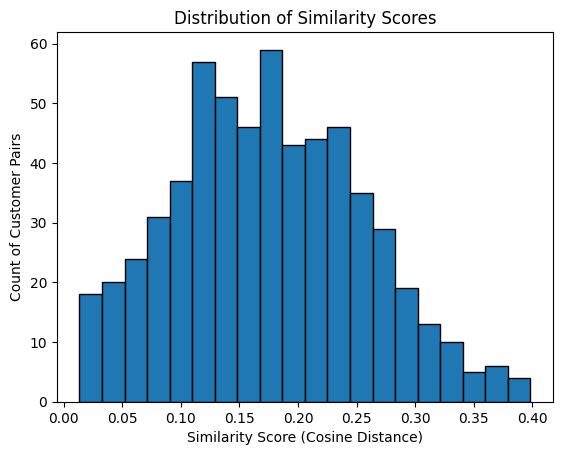

In [84]:
plt.hist(distances[:, 1:].flatten(), bins=20, edgecolor="black")
plt.xlabel("Similarity Score (Cosine Distance)")
plt.ylabel("Count of Customer Pairs")
plt.title("Distribution of Similarity Scores")
plt.show()
